## Overall problem definition 
Find a way to calculate the global min/max of a function

## Overall approach explanation - 
Stochastic gradient descent works well, but not when there are many local extrema.  Instead of trying to work around those local extrema, what if we could make them vanish?  Then we could progressively level out the hyper-surface, eliminating local extrema, until the remaining two are global

### Clarification questions - 

1. What is meant by “vanishing”?  In the simplest sense, this means that the function is modified such that no peak or valley emerges.  In more detail, this means that the first derivative never crosses the x axis in 2D.  What does this mean in N-dimensions?  What else can we say about this process?
    
1. Is it even possible to modify a function such that a certain extremum will vanish?  We don’t know the coordinates or the value of the extrema, so this process would have to somehow rely on a global property of continuous (or perhaps restrict to polynomial?) functions and their extrema.  What such properties might exist?

To help visualize this, let's look at a function with multiple extrema, the Rastrigin function.

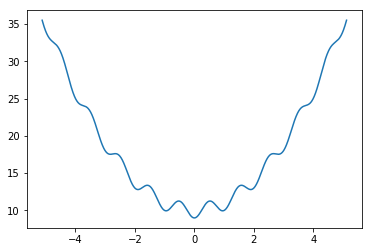

In [15]:
import numpy as np
import matplotlib.pyplot as plt
A = 10
x = np.linspace(-5.12, 5.12, 1000)
y = A + x**2 - np.cos(2*np.pi*x)
plt.plot(x, y)
plt.show()

